In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
import torch
import pickle
import utilities
import preprocess
import similarities
import parameters
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations, product

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

In [2]:
result_file_name = 'embedding_tuning_ohsumed-3.p'

In [3]:
data = 'ohsumed'

In [4]:
embedding_methods = ['all-MiniLM-L6-v2', 
                     'all-MiniLM-L12-v2', 
                     'all-mpnet-base-v1', 
                     'all-mpnet-base-v2', 
                     'all-roberta-large-v1', 
                     'all-distilroberta-v1']

In [4]:
random_state = parameters.random_state
np.random.seed(random_state)
data_paths = parameters.data_paths

In [5]:
df = utilities.read_data(data_paths[data])
X = df['text'].apply(preprocess.preprocess_text)
y = df.drop(['text'], axis=1)

In [6]:
X

0        haemophilus influenzae meningitis with prolong...
1        augmentation mentoplasty using mersilene mesh ...
2        multiple intracranial mucoceles associated wit...
3        replacement of an aortic valve cusp after neon...
4        mucosal intussusception to avoid ascending cho...
                               ...                        
23981    radiotherapy of advanced laryngeal cancer usin...
23982    fatty acids in human platelets and plasma fish...
23983    very severe self poisoning lithium carbonate i...
23984    indications for radiography in patients with a...
23985    effect of total parenteral nutrition with xyli...
Name: text, Length: 23986, dtype: object

In [9]:
embedding_method = 'all-mpnet-base-v1'
# all-MiniLM-L6-v2

before_X_num = utilities.vectorize_data(X, embedding_method)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/591 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

ChunkedEncodingError: ("Connection broken: ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)", ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [ ]:
before_X_num

In [7]:
total_samples = dict(y.sum())

In [8]:
def calculate_between_class_similarities(col1, col2, X, y):
    
    sims = []
    
    for idx1 in y[y[col1]==1].index:
        for idx2 in y[y[col2]==1].index:
            sims.append(similarities.vector_similarity(X.loc[idx1], X.loc[idx2]))
    
    return sum(sims)/len(sims)     

In [9]:
def calculate_similarity_matrix(X, y, sim_method='cosine'):
    
    import similarities
    
    sim_df = pd.DataFrame(index=y.columns, columns=y.columns)
    
    for col in y.columns:
        sim_df.loc[col, col] = similarities.calculate_similarity_within_classes(X.loc[y[y[col]==1].index], sim_calculation_type='average')
    
    for col1, col2 in list(combinations(y.columns, 2)):
        sim_df.loc[col1, col2] = similarities.calculate_similarity_between_classes(X.loc[y[y[col1]==1].index], X.loc[y[y[col2]==1].index], sim_calculation_type='average')
    
    return sim_df

def calculate_similarity_matrix(X, y, sim_method='cosine'):
    
    import similarities
    import ray
    ray.init(num_cpus=2)
    
    @ray.remote
    def run1(indexes):
        sims = similarities.calculate_similarity_within_classes(indexes, 'average')
        return sims

    sim_df = pd.DataFrame(index=y.columns, columns=y.columns)
    
    futures = [run1.remote(X.loc[y[y[col]==1].index]) for col in y.columns]
    results = ray.get(futures)
    
    for idx, col in enumerate(y.columns):
        sim_df.loc[col, col] = results[idx]
    
    @ray.remote
    def run2(indexes1, indexes2):
        sims = similarities.calculate_similarity_between_classes(indexes1, indexes2, 'average')
        return sims
    
    futures2 = [run2.remote(X.loc[y[y[col1]==1].index], X.loc[y[y[col2]==1].index]) for col1, col2 in list(combinations(y.columns, 2))]
    results2 = ray.get(futures2)    
    
    for idx, cols in enumerate(list(combinations(y.columns, 2))):
        
        col1, col2 = cols
        sim_df.loc[col1, col2] = results2[idx]
    
    return sim_df

In [10]:
def calculate_matrix_score(sim_df):
    scores = []
    for col in sim_df.columns:
        scores.append((sim_df.loc[col, col] - sim_df.loc[col].drop(col).max())/sim_df.loc[col, col])
    return scores

In [11]:
def vectorize_data(text, model):
    
    # model = SentenceTransformer(model_name)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    vectors = model.encode(text, convert_to_tensor=False, device=device)
    
    return vectors

In [12]:
def create_train_data(X, y, samples):
    
    train_set = []

    for col in y.columns:

        idxs = y[y[col]==1].index
        
        tmp_set = X.loc[idxs].sample(samples[col])
        
        for pair in combinations(tmp_set, 2):
            train_set.append(InputExample(texts=list(pair), label=1.0))

    for col1, col2 in combinations(y.columns,2):
        
        sample_num = samples[(col1, col2)]
        idxs1 = y[(y[col1]==1)&(y[col2]==0)].index
        idxs2 = y[(y[col2]==1)&(y[col1]==0)].index
        tmp_samples = random.sample(list(product(idxs1, idxs2)), sample_num)
        
        tmp_set1 = X.loc[[i[0] for i in tmp_samples]]
        tmp_set2 = X.loc[[i[1] for i in tmp_samples]]
        
        for pair in zip(tmp_set1, tmp_set2):
            train_set.append(InputExample(texts=list(pair), label=0.0))

    print(len(train_set))
    
    return train_set

In [13]:
def create_initial_samples(y, sample_nums, between_col):    
    samples = {}

    for col in y.columns:
        samples[col] = sample_nums[col]

    for col1, col2 in combinations(y.columns, 2):
        samples[(col1, col2)] = between_col[(col1, col2)]
        
    return samples

In [14]:
def update_sample_sizes(simd_df, samples):
    
    for col1, col2 in combinations(simd_df.columns, 2):
        if simd_df.loc[col1, col2] > 0.2:
            samples[(col1, col2)] = int((1/(1-simd_df.loc[col1, col2]))*samples[(col1, col2)])
        
        if samples[(col1, col2)] > total_samples[col1]*total_samples[col2]:
            samples[(col1, col2)] = int(total_samples[col1]*total_samples[col2])
            
    for col in simd_df.columns:
        if simd_df.loc[col, col] < 0.5:
            samples[col] = int((1/simd_df.loc[col, col])*samples[col])
            
        if samples[col] > total_samples[col]:
            samples[col] = total_samples[col]
            
    return samples

In [15]:
if not os.path.exists(result_file_name):
    tuning_results = {}
    with open(result_file_name, 'wb') as f:
        pickle.dump(tuning_results, f)

In [16]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [17]:
def fill_symmetry(sim_df):
    for col1, col2 in combinations(sim_df.columns, 2):
        sim_df.loc[col2, col1] = sim_df.loc[col1, col2] 
    return sim_dfb

In [18]:
def scoring(sim_df):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}') 

In [19]:
with open('embedding_results_ohsumed.p', 'rb') as f:
    initial_results = pickle.load(f)

In [20]:
sample_nums = dict(zip(y.columns, [100]*len(y.columns)))
sample_nums['c01'] = 200
sample_nums['c05'] = 200
sample_nums['c10'] = 200
sample_nums['c20'] = 200
sample_nums['c15'] = 200
sample_nums['c21'] = 200

In [21]:
between_col_samples = dict(zip(list(combinations(y.columns,2)), [100]*len(list(combinations(y.columns,2)))))
between_col_samples[('c01', '20')] = 200
between_col_samples[('c02', 'c20')] = 400
between_col_samples[('c05', 'c21')] = 200
between_col_samples[('c13', 'c16')] = 200
between_col_samples[('c15', 'c20')] = 200
between_col_samples[('c15', 'c20')] = 200

In [22]:
embedding_method = 'all-mpnet-base-v1'
# all-MiniLM-L6-v2

before_X_num = utilities.vectorize_data(X, embedding_method)
sim_df2 = calculate_similarity_matrix(before_X_num, y)

175050


C:\Users\IsmailKaraman\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/29175 [00:00<?, ?it/s]

Iteration:   0%|          | 0/29175 [00:00<?, ?it/s]

fit time:  313.83116480112074
sim calc time:  241.56775644222895


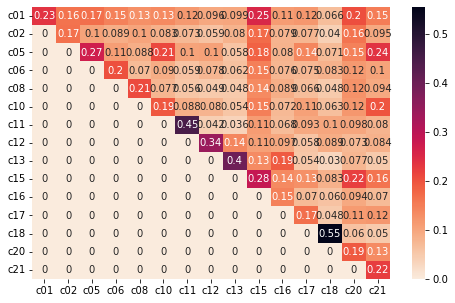

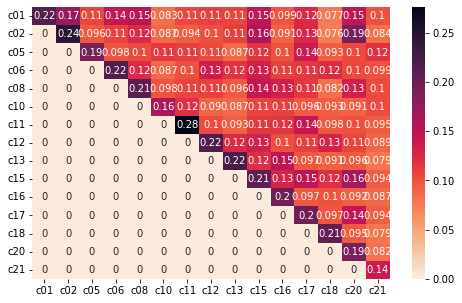

In [23]:
samples = create_initial_samples(y, sample_nums, between_col_samples)
i = 0       
for seed in range(1):
    
    model = SentenceTransformer(embedding_method, device='cuda')

    t1 = time.time() 
    train_set = create_train_data(X, y, samples)
    
    train_dataloader = DataLoader(train_set, shuffle=True, batch_size=6)
    train_loss = losses.CosineSimilarityLoss(model)
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=50)
    t2 = time.time()
    print('fit time: ',(t2-t1)/60)
    X_num = vectorize_data(X, model)
    X_num = pd.Series([np.squeeze(i) for i in X_num])
    sim_df = calculate_similarity_matrix(X_num, y)
    t3 = time.time()
    print('sim calc time: ',(t3-t2)/60)
    plt.figure(i, figsize=(8,5)) 
    sns.heatmap(sim_df.fillna(0), annot=True,
                         xticklabels=sim_df.columns,
                         yticklabels=sim_df.columns, cmap="rocket_r")
    plt.show()
    i += 1
    
    
    
    plt.figure(i, figsize=(8,5)) 
    sns.heatmap(sim_df2.fillna(0), annot=True,
                         xticklabels=sim_df2.columns,
                         yticklabels=sim_df2.columns, cmap="rocket_r")
    

In [24]:
stop

NameError: name 'stop' is not defined

In [ ]:
plt.figure(i, figsize=(8,5)) 
sns.heatmap(sim_df.fillna(0), annot=True,
                     xticklabels=sim_df.columns,
                     yticklabels=sim_df.columns, cmap="rocket_r")
plt.show()
i += 1



plt.figure(i, figsize=(8,5)) 
sns.heatmap(sim_df2.fillna(0), annot=True,
                     xticklabels=sim_df2.columns,
                     yticklabels=sim_df2.columns, cmap="rocket_r")

In [ ]:
fit time:  59.23926930427551
sim calc time:  252.00236877600352

In [ ]:
tuning_results['all-MiniLM-L6-v2']

In [ ]:
with open(result_file_name, 'rb') as f:
    tuning_results = pickle.load(f)

In [ ]:
aa.keys()

In [ ]:
def scoring(sim_df):    
    scores = calculate_matrix_score(sim_df)[:-1]
    print(f'max: {max(scores):.2f}, min: {min(scores):.2f}, avg: {sum(scores)/len(scores):.2f}')

    l_sum = 100*np.diag(sim_df).sum()/12 - (sim_df.sum().sum()-np.diag(sim_df).sum())/66
    print(f'{l_sum:.2f}') 

In [ ]:
for k,v in tuning_results.items():
    print(k)
    print('before')
    scoring(v[0])
    print('after')
    scoring(v[1])
    
    # fig, axes = plt.subplots(1, 2, figsize=(16,5), squeeze=False)
    fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax1, ax2 = axes
    sns.heatmap(v[0].fillna(0), annot=True,
                        xticklabels=v[0].columns,
                        yticklabels=v[0].columns, ax=ax1, cmap="rocket_r")
    sns.heatmap(v[1].fillna(0), annot=True,
                        xticklabels=v[1].columns,
                        yticklabels=v[1].columns, ax=ax2, cmap="rocket_r")

    plt.show()

    print('*'*70)